Improvements:
- Fixing + Cleaning Dataset
- Adding / Changing Layers
- Implementing k-fold cross validation
- Implementing GridSearch

In [2]:
# VARIABLES

MODEL_NUMBER = 12
LEARNING_RATE = 0.000160
DATA_AUG_DIFF = 'hard'
VAL_SET_SIZE = 0.1
TEST_SET_SIZE = 0.1
RANDOM_STATE = 0
BATCH_SIZE = 16
LOSS_FUNCTION = 'custom'
EPOCHS = 30
OPTICAL_DEPTH = '-4.2'

### Inputs

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/MyDrive/cleandc.zip -d /content/

Archive:  /content/gdrive/MyDrive/cleandc.zip
   creating: /content/cleandc/
  inflating: /content/cleandc/xydata_20211021_023153_3620110077.npz  
  inflating: /content/cleandc/xydata_20171111_012544_3610108077.npz  
  inflating: /content/cleandc/xydata_20220730_012426_3620108076.npz  
  inflating: /content/cleandc/xydata_20200805_124938_3620108077.npz  
  inflating: /content/cleandc/xydata_20211025_013431_3620112077.npz  
  inflating: /content/cleandc/xydata_20180116_235048_3610108077.npz  
  inflating: /content/cleandc/xydata_20220406_150859_3620108077.npz  
  inflating: /content/cleandc/xydata_20210525_053903_3620110077.npz  
  inflating: /content/cleandc/xydata_20210329_053958_3620110077.npz  
  inflating: /content/cleandc/xydata_20200817_001801_3620110077.npz  
  inflating: /content/cleandc/xydata_20220410_151631_3620108077.npz  
  inflating: /content/cleandc/xydata_20190814_121420_3620112077.npz  
  inflating: /content/cleandc/xydata_20191208_124810_3610108077.npz  
  inflating: 

In [6]:
# import os
# to_remove = os.listdir('/content/dataset/fixing_dataset')
# aba = []
# for i in to_remove:
#   aba.append('/content/dataset/fixing_dataset/'+i)
# # print(*aba), !rm

### Loading Data + Normalizing Outliers

In [7]:
!rm cleandc/.DS_Store

In [8]:
import os
from itertools import combinations

path = '/content/cleandc/'
filenames = os.listdir(path)

In [9]:
X = []
Y = []

for s in filenames:
  obs = np.load(path+'/'+s)
  aia_1600 = obs['x'][0,:,:]
  aia_1700 = obs['x'][1,:,:]
  aia_304 = obs['x'][2,:,:]
  aia_193 = obs['x'][3,:,:]
  aia_171 = obs['x'][4,:,:]
  data_x = np.stack(tuple([aia_1600, aia_1700, aia_304]))
  temp_5_2 = obs['y'][0,:,:]
  temp_4_2 = obs['y'][1,:,:]
  temp_3_2 = obs['y'][2,:,:]
  if OPTICAL_DEPTH == '-5.2':
    data_y = temp_5_2
  elif OPTICAL_DEPTH == '-4.2':
    data_y = temp_4_2
  elif OPTICAL_DEPTH == '-3.2':
    data_y = temp_3_2
  else:
    print("INVALID OPTICAL DEPTH")
  X.append(np.transpose(data_x, [1, 2, 0]))
  Y.append(data_y)

### Data Splits

In [10]:
from sklearn.model_selection import train_test_split
valid_size = VAL_SET_SIZE
test_size = TEST_SET_SIZE
combine_size = valid_size + test_size
random_state = RANDOM_STATE
x_train, x_combine, y_train, y_combine = train_test_split(X, Y, test_size=combine_size, random_state = random_state)
x_val, x_test, y_val, y_test = train_test_split(x_combine, y_combine, test_size = test_size/combine_size, random_state = random_state)

In [11]:
datasets = [x_train, x_val, x_test, y_train, y_val, y_test]
x_train, x_val, x_test, y_train, y_val, y_test = [np.asarray(a, dtype=object) for a in datasets]

In [12]:
x_obsids = filenames.copy()
y_obsids = filenames.copy()
obs_x_train, obs_x_combine, obs_y_train, obs_y_combine = train_test_split(x_obsids, y_obsids, test_size=combine_size, random_state = random_state)
obs_x_val, obs_x_test, obs_y_val, obs_y_test = train_test_split(obs_x_combine, obs_y_combine, test_size = test_size/combine_size, random_state = random_state)

### Data Augmentation

In [28]:
import cv2
from tensorflow.keras.utils import Sequence
from PIL import ImageEnhance, Image
import torchvision.transforms as transforms

class DataGenerator(Sequence):
    def __init__(self, X, Y, target_size, batch_size, difficulty):
        self.X = X
        self.Y = Y
        self.target_size = target_size
        self.batch_size = batch_size
        self.difficulty = difficulty
        self.processed_X = self.preprocess_X(X)
        self.processed_Y = self.preprocess_Y(Y)

    def __len__(self):
        return int(len(self.processed_X) / self.batch_size)

    def __getitem__(self, index):
        batch_X = self.processed_X[index*self.batch_size : (index+1)*self.batch_size]
        batch_Y = self.processed_Y[index*self.batch_size : (index+1)*self.batch_size]
        #print(processed_X.shape)

        return np.asarray(batch_X), np.asarray(batch_Y)

    def preprocess_X(self, X):
        if self.difficulty == 'easy':
          processed = [self.padding_rgb(x) for x in X]

        elif self.difficulty == 'medium':
          flipped = [[x, self.flip(x, 0), self.flip(x, 1), self.flip(x, -1)] for x in X]
          flipped_arr = []
          for image in flipped:
            for flip in image:
              flipped_arr.append(flip)
          noised = [self.noise(x) for x in flipped_arr]
          jittered = [self.jitter(x) for x in noised]
          padded = [self.padding_rgb(x) for x in jittered]
          processed = padded

        elif self.difficulty == 'hard':
          flipped = [[x, self.flip(x, 0), self.flip(x, 1), self.flip(x, -1)] for x in X]
          flipped_arr = []
          for image in flipped:
            for flip in image:
              flipped_arr.append(flip)
          noised = [self.noise(x, 40) for x in flipped_arr]
          jitterred = [self.jitter(x, b = 0.6, c = 0.4, s = 0.8, h = 0.2) for x in noised]
          padded = [self.padding_rgb(x) for x in jitterred]
          processed = padded
        return processed

        pass

    def preprocess_Y(self, Y):
        if self.difficulty == 'easy':
          processed = [self.padding_bw(y) for y in Y]

        elif self.difficulty == 'medium':
          flipped = [[y, self.flip(y, 0), self.flip(y, 1), self.flip(y, -1)] for y in Y]
          flipped_arr = []
          for image in flipped:
            for flip in image:
              flipped_arr.append(flip)
          padded = [self.padding_bw(y) for y in flipped_arr]
          processed = padded

        elif self.difficulty == 'hard':
          flipped = [[y, self.flip(y, 0), self.flip(y, 1), self.flip(y, -1)] for y in Y]
          flipped_arr = []
          for image in flipped:
            for flip in image:
              flipped_arr.append(flip)
          padded = [self.padding_bw(y) for y in flipped_arr]
          processed = padded
        return processed

        pass

    def padding_rgb(self, image):
        #print("HERE", image.shape)

        ih, iw, c = image.shape
        fh, fw = self.target_size
        blank = (0,0,0)
        result = np.full((fh, fw, c), blank, dtype=np.float32)
        #print("checkpoint 1", result.dtype)

        x_center = (fw - iw) // 2
        y_center = (fh - ih) // 2

        result[y_center:y_center+ih,
              x_center:x_center+iw] = image

        return result
        pass

    def padding_bw(self, image):
        ih, iw = image.shape
        fh, fw = self.target_size
        blank = 0
        result = np.full((fh,fw), blank, dtype=np.float32)
        #print("checkpoint 2", result.dtype)

        x_center = (fw - iw) // 2
        y_center = (fh - ih) // 2

        result[y_center:y_center+ih,
              x_center:x_center+iw] = image

        return result
        pass

    def jitter(self, image, b=0.2, c=0.2, s=0.2, h=0.1):
        pre_img = Image.fromarray(np.uint8(image))
        transform = transforms.ColorJitter(
        brightness=b, contrast=c, saturation=s, hue=h)
        result = transform(pre_img)
        result = np.array(result)
        return result

    def brightness(self, image, factor=1):
        enhancer = ImageEnhance.Brightness(image)
        result = enhancer.enhance(factor)
        return result

    def noise(self, image, factor = 20):
        gauss_noise = np.zeros(image.shape, dtype = np.uint8)
        cv2.randn(gauss_noise, 255, factor)
        gauss_noise = (gauss_noise*0.5).astype(np.uint8)
        result = cv2.add(image.astype(np.uint8), gauss_noise)
        return result

    def flip(self, image, flip_factor):
        flipped_img = cv2.flip(image, flip_factor)
        # 0: vertical, 1: horizontal, -1: both
        return flipped_img

    def on_epoch_end(self):
        # Optional method to perform any action at the end of each epoch
        pass

In [29]:
from math import ceil

max_x = np.nanmax([a.shape[1] for a in X])
max_y = np.nanmax([a.shape[0] for a in X])
max_x, max_y = ceil(max_x/4)*4, ceil(max_y/4)*4
target_size = (max_y, max_x)


batch_size = BATCH_SIZE


train_gen = DataGenerator(X = x_train, Y = y_train, target_size = target_size, batch_size = batch_size, difficulty = DATA_AUG_DIFF)
valid_gen = DataGenerator(X = x_val, Y = y_val, target_size = target_size, batch_size = batch_size, difficulty = DATA_AUG_DIFF)
test_gen = DataGenerator(X = x_test, Y = y_test, target_size = target_size, batch_size = len(x_test), difficulty = 'easy')

### Custom Loss Function
Trying:
- MSE
- L1

In [15]:
def mse(y_true, y_pred):
  mse = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
  return mse

def l1(y_true, y_pred):
  l1 = tf.reduce_mean(tf.abs(y_true-y_pred))
  return l1

def custom(y_true, y_pred):
  # return mse(y_true, y_pred)+0.5*l1(y_true,y_pred)
  return mse(y_true, y_pred)+0.75*l1(y_true, y_pred)

# def vgg(y_true, y_pred):
#   vgg = VGG16(weights = 'imagenet', include_top=False)
#   vgg.trainable = False
#   y_true_rgb = tf.repeat(y_true, 3, axis=-1)
#   y_pred_rgb = tf.repeat(y_pred, 3, axis=-1)
#   y_true_rgb = tf.keras.applications.vgg16.preprocess_input(y_true_rgb)
#   y_pred_rgb = tf.keras.applications.vgg16.preprocess_input(y_pred_rgb)
#   target_features = vgg(y_true_rgb)['block4_conv2']
#   predicted_features = vgg(y_pred_rgb)['block4_conv2']
#   mse_loss = tf.reduce_mean(tf.square(target_features - predicted_features))
#   return mse_loss

### Building Model

In [30]:
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.layers import *
from keras import optimizers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import Input, Conv2D, Lambda

from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import Lambda
from tensorflow.keras.models import Model

In [31]:
# first u-net
# def create_model(dropout_rate = 0.3):
#     model = Sequential()
#     input_shape = [target_size[0], target_size[1], 3]
# #entry block
#     model.add(Conv2D(16, (5, 5), input_shape = input_shape, activation = 'relu', padding = 'same'))
# #block 1
#     model.add(Conv2D(16, (5, 5), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2,2)))
#     model.add(Dropout(dropout_rate))
#     model.add(Conv2D(32, (3, 3), activation = 'relu'))

#     model.add(Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2,2)))
#     model.add(Dropout(dropout_rate))
#     model.add(Conv2D(64, (3, 3), activation = 'relu'))
# #block 2
#     model.add(Conv2D(64, (3, 3), activation = 'relu'))
#     model.add(Conv2D(64, (3, 3), activation = 'relu'))
#     model.add(Conv2DTranspose(64, (17, 17), strides = (2, 2), activation = 'relu'))

#     model.add(Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(Conv2DTranspose(32, (18, 18), output_padding = (1,0) ,strides = (2, 2), activation = 'relu'))
# #block 3
#     model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
#     model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
#     model.add(Conv2D(1, (1, 1)))
#     model.compile(loss = loss, optimizer = optimizers.Adam(learning_rate = 0.0001, amsgrad = True), metrics = [loss, 'accuracy'])

#     return model

In [32]:
def get_model(dropout_rate = 0.3):
  input_shape = (target_size[0], target_size[1], 3)
  inputs = keras.Input(shape = input_shape)

  # Entry block
  x = layers.Conv2D(16, 5, input_shape = input_shape, activation = 'relu', padding="same")(inputs)
  previous_block_activation = x  # Set aside residual

  # Block 1
  x = layers.Conv2D(16, (5, 5), activation = 'relu', padding='same')(x)
  x = layers.MaxPooling2D(pool_size = (2,2), padding='same')(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  residual = layers.Conv2D(32, 1, strides = 2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])
  previous_block_activation = x

  #Block 2
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.MaxPooling2D(pool_size = (2,2), padding='same')(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
  residual = layers.Conv2D(64, 1, strides = 2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])
  previous_block_activation = x

  #Block 3
  x = layers.Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.Conv2DTranspose(64, (17, 17), activation = 'relu', padding='same')(x)
  x = layers.UpSampling2D(2)(x)
  residual = layers.UpSampling2D(2)(previous_block_activation)
  residual = layers.Conv2D(64, 1, padding="same")(residual)
  x = layers.add([x, residual])
  previous_block_activation = x

  #Block 4
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.Conv2DTranspose(32, (18, 18), activation = 'relu', padding='same')(x)
  x = layers.UpSampling2D(2)(x)
  residual = layers.UpSampling2D(2)(previous_block_activation)
  residual = layers.Conv2D(32, 1, padding="same")(residual)
  x = layers.add([x, residual])
  previous_block_activation = x

  #Block 5
  x = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
  residual = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(previous_block_activation)
  x = layers.add([x, residual])

  #Output
  outputs = layers.Conv2D(1, (1, 1))(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 292, 188, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 292, 188, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 292, 188, 16  6416        ['conv2d[0][0]']                 
                                )                                                             

In [33]:
def pixel_shuffle(x, upsampling_factor):
    batch_size = tf.shape(x)[0]
    height = tf.shape(x)[1]
    width = tf.shape(x)[2]
    channels = x.shape.as_list()[3]

    # Reshape the input tensor
    reshaped = tf.reshape(x, [batch_size, height, width, upsampling_factor, upsampling_factor, channels // (upsampling_factor ** 2)])

    # Transpose the dimensions to shuffle the pixels
    transposed = tf.transpose(reshaped, [0, 1, 3, 2, 4, 5])

    # Reshape to obtain the final output tensor
    output = tf.reshape(transposed, [batch_size, height * upsampling_factor, width * upsampling_factor, channels // (upsampling_factor ** 2)])

    return output

In [34]:
def get_ps_model(dropout_rate = 0.3):
  input_shape = (target_size[0], target_size[1], 3)
  inputs = keras.Input(shape = input_shape)

  ### [First half of the network: downsampling inputs] ###

  # Entry block
  x = layers.Conv2D(16, 5, input_shape = input_shape, activation = 'relu', padding="same")(inputs)
  previous_block_activation = x  # Set aside residual

  # Block 1
  x = layers.Conv2D(16, (5, 5), activation = 'relu', padding='same')(x)
  x = layers.MaxPooling2D(pool_size = (2,2), padding='same')(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  residual = layers.Conv2D(32, 1, strides = 2, padding='same')(previous_block_activation)
  x = layers.Concatenate()([x, residual])
  previous_block_activation = x

  #Block 2
  x = layers.Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.MaxPooling2D(pool_size = (2,2), padding='same')(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Conv2D(128, (3, 3), activation = 'relu', padding='same')(x)
  residual = layers.Conv2D(128, 1, strides = 2, padding='same')(previous_block_activation)
  x = layers.Concatenate()([x, residual])
  previous_block_activation = x

  #Block 3
  x = layers.Conv2D(128, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.Conv2D(128, (3, 3), activation = 'relu', padding='same')(x)
  # x = Lambda(lambda a: pixel_shuffle(a, upsampling_factor = 2))(x)
  # residual = Lambda(lambda x: pixel_shuffle(x, upsampling_factor = 2))(previous_block_activation)
  sub_layer = Lambda(lambda x:tf.nn.depth_to_space(x,2))
  x = sub_layer(inputs=x)
  residual = sub_layer(inputs=previous_block_activation)

  residual = layers.Conv2D(32, 1, padding="same")(residual)
  x = layers.Concatenate()([x, residual])
  previous_block_activation = x

  #Block 4
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
  # x = Lambda(lambda x: pixel_shuffle(x, upsampling_factor = 2))(x)
  # residual = Lambda(lambda x: pixel_shuffle(x, upsampling_factor = 2))(previous_block_activation)
  sub_layer = Lambda(lambda x:tf.nn.depth_to_space(x,2))
  x = sub_layer(inputs=x)
  residual = sub_layer(inputs=previous_block_activation)

  residual = layers.Conv2D(8, 1, padding="same")(residual)
  x = layers.Concatenate()([x, residual])
  previous_block_activation = x

  #Block 5
  x = layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x)
  residual = layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(previous_block_activation)
  x = layers.Concatenate()([x, residual])

  #Output
  outputs = layers.Conv2D(1, (1, 1))(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model


# Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()

# Build model
# model = get_ps_model()
# model.summary()

In [35]:
if LOSS_FUNCTION == 'mse':
  loss_fun = mse
elif LOSS_FUNCTION == 'l1':
  loss_fun = l1
elif LOSS_FUNCTION == 'custom':
  loss_fun = custom
else:
  print("INVALID LOSS FUNCTION")
model.compile(loss = loss_fun, optimizer = optimizers.Adam(learning_rate = LEARNING_RATE, amsgrad = True))
# model.fit(train_gen, steps_per_epoch = len(train_gen), validation_data = valid_gen, validation_steps = len(test_gen), epochs = 30, use_multiprocessing = True)

In [36]:
from keras.callbacks import History
history = History()
with tf.device('/device:GPU:0'):
  model.fit(train_gen, steps_per_epoch = len(train_gen), validation_data = valid_gen, validation_steps = len(valid_gen), epochs = EPOCHS, use_multiprocessing = True, callbacks = [history])

Epoch 1/30
27/27 [==============================] - 19s 643ms/step - loss: 5818.9136 - val_loss: 3678.0674
Epoch 2/30
27/27 [==============================] - 15s 567ms/step - loss: 3649.0330 - val_loss: 3262.6897
Epoch 3/30
27/27 [==============================] - 15s 536ms/step - loss: 3689.2581 - val_loss: 3391.3142
Epoch 4/30
27/27 [==============================] - 15s 536ms/step - loss: 3278.9624 - val_loss: 3068.5852
Epoch 5/30
27/27 [==============================] - 15s 540ms/step - loss: 3260.7896 - val_loss: 3066.8000
Epoch 6/30
27/27 [==============================] - 16s 577ms/step - loss: 3281.0681 - val_loss: 2952.8303
Epoch 7/30
27/27 [==============================] - 15s 563ms/step - loss: 3104.9153 - val_loss: 3010.8145
Epoch 8/30
27/27 [==============================] - 16s 576ms/step - loss: 3040.6936 - val_loss: 3046.5247
Epoch 9/30
27/27 [==============================] - 15s 569ms/step - loss: 3057.9177 - val_loss: 3062.9961
Epoch 10/30
27/27 [==================

### Model Evaluation

In [37]:
predictions = model.predict(test_gen, steps = len(test_gen))
inputs = []
corrects = []

for i in range(len(predictions)):
  input = []
  for j in range(3):
    input.append(test_gen.__getitem__(0)[0][i,:,:,j])

  inputs.append(input)
  corrects.append(test_gen.__getitem__(0)[1][i,:,:])

1/1 [==============================] - 0s 295ms/step


In [50]:
for i in range(len(predictions)):
  outputs = np.stack(tuple([inputs[i][0], inputs[i][1], inputs[i][2], corrects[i], predictions[i][:,:,0]/np.nanmax(predictions[i])*255]))
  predict_nf = np.nanmax(predictions[i])
  np.savez('/content/predictions_unet{}_{}.npz'.format(MODEL_NUMBER, obs_x_test[i][7:33]), layers = outputs, nf = predict_nf)

xydata_20171219_053521_3610108077.npz


Text(0.5, 1.0, 'Output | Prediction Overlay - Temperature @ -4.2')

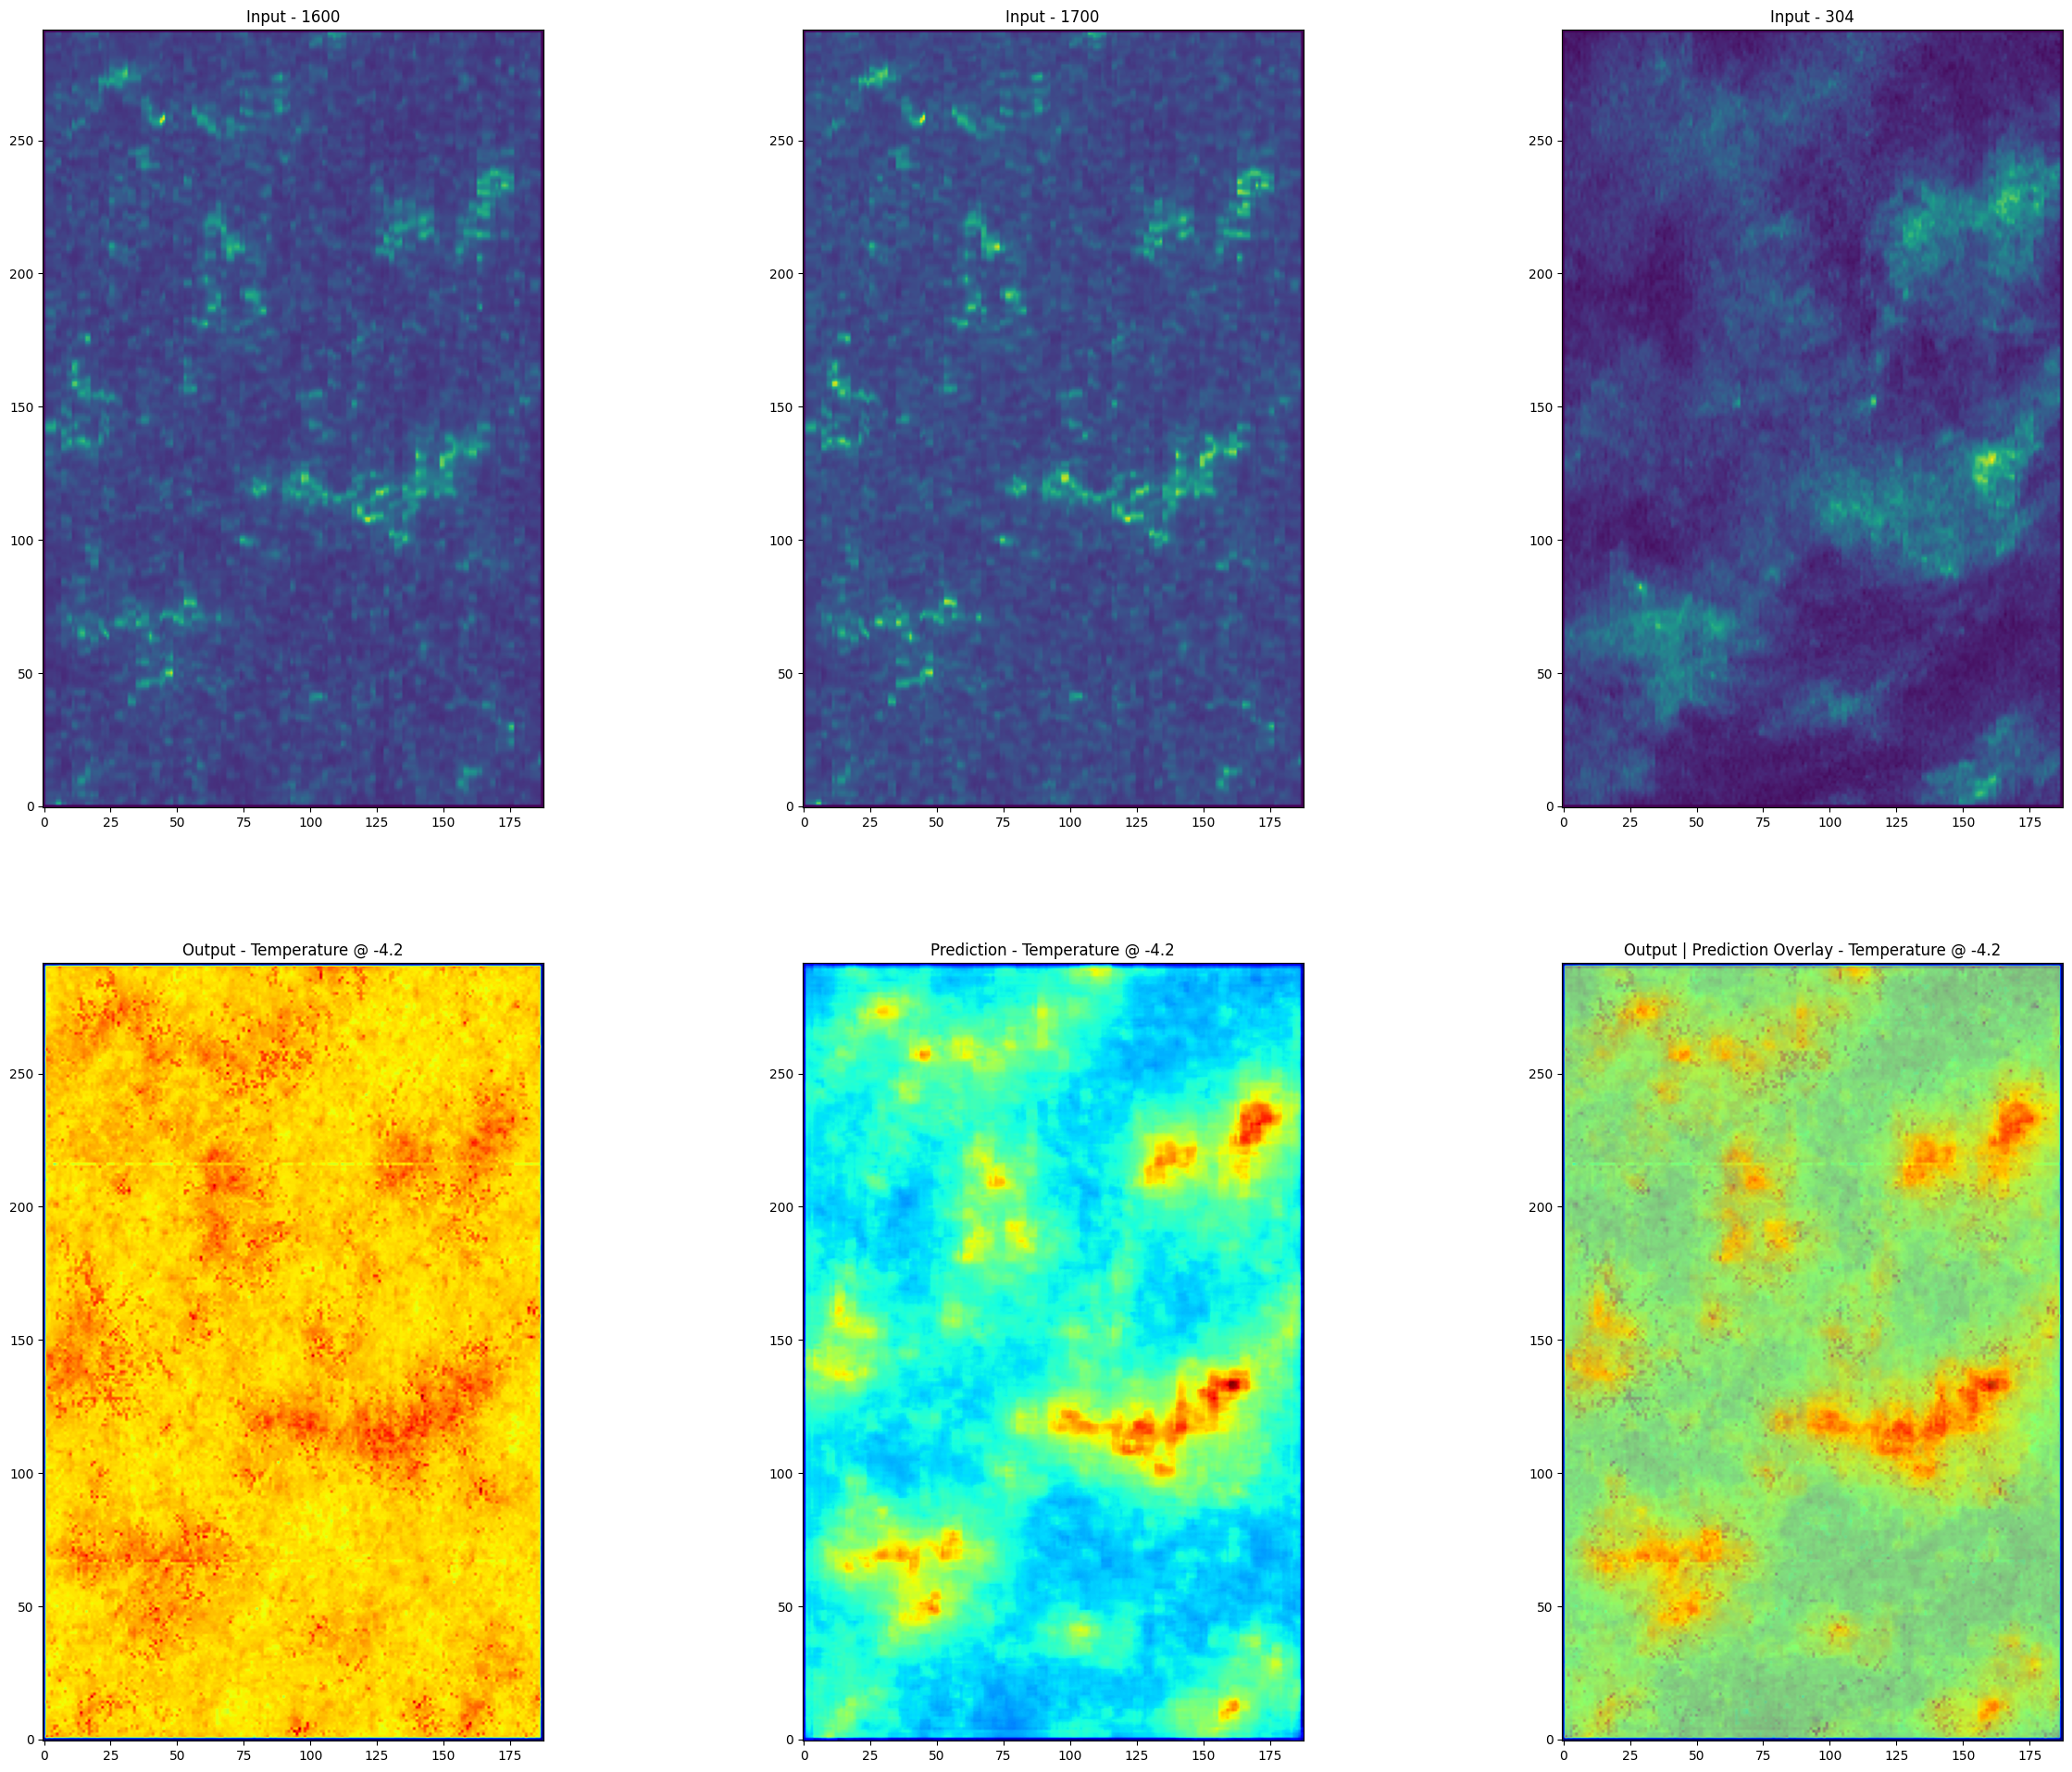

In [38]:
i = 0

print(obs_x_test[i])

fig, ax = plt.subplots(2, 3, figsize = [30,24])
ax[0][0].imshow(inputs[i][0], origin = 'lower'); ax[0][0].set_title('Input - 1600') #1600
ax[0][1].imshow(inputs[i][1], origin = 'lower'); ax[0][1].set_title('Input - 1700') #1700
ax[0][2].imshow(inputs[i][2], origin = 'lower'); ax[0][2].set_title('Input - 304') #304
ax[1][0].imshow(corrects[i], cmap = 'jet', origin = 'lower'); ax[1][0].set_title('Output - Temperature @ {}'.format(OPTICAL_DEPTH)) #temperature
sh = predictions[i]/np.nanmax(predictions[i])*255
ax[1][1].imshow(sh, cmap='jet', origin = 'lower'); ax[1][1].set_title('Prediction - Temperature @ {}'.format(OPTICAL_DEPTH)) #predicted

#overlayed predicted and correct temp
ax[1][2].imshow(corrects[i], cmap = 'jet', origin = 'lower'); ax[1][2].imshow(predictions[i], origin='lower', alpha = 0.5*(corrects[i]>0), cmap = 'jet'); ax[1][2].set_title('Output | Prediction Overlay - Temperature @ {}'.format(OPTICAL_DEPTH))

In [53]:
model.save('unet{} - (optical depth = {}, loss = {}, lr = {}, epochs = {})(, data+).h5'.format(MODEL_NUMBER, OPTICAL_DEPTH, LOSS_FUNCTION, LEARNING_RATE, EPOCHS))

In [25]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

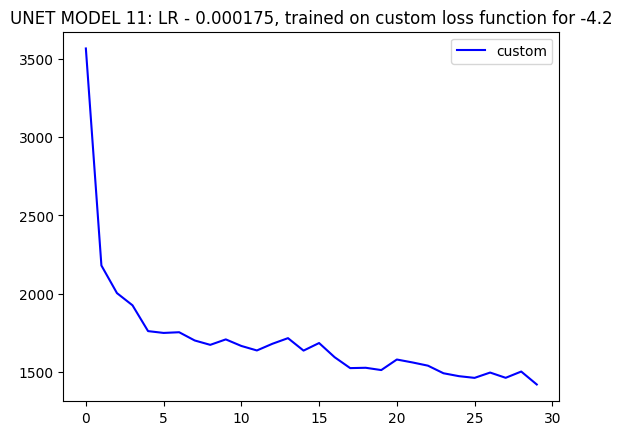

In [55]:
# plt.plot(range(30), history.history['loss'], 'r')
plt.plot(range(30), history.history['loss'], 'b')
plt.title("UNET MODEL {}: LR - {}, trained on {} loss function for {}".format(MODEL_NUMBER, LEARNING_RATE, LOSS_FUNCTION, OPTICAL_DEPTH))
plt.legend([
    LOSS_FUNCTION
    # ,'Val_Loss'
])
# plt.savefig("unet4.png")

### Visualization

In [56]:
aa = np.transpose(np.expand_dims(np.asarray(inputs[i]), axis=0), [0, 2, 3, 1])

1/1 [==============================] - 2s 2s/step


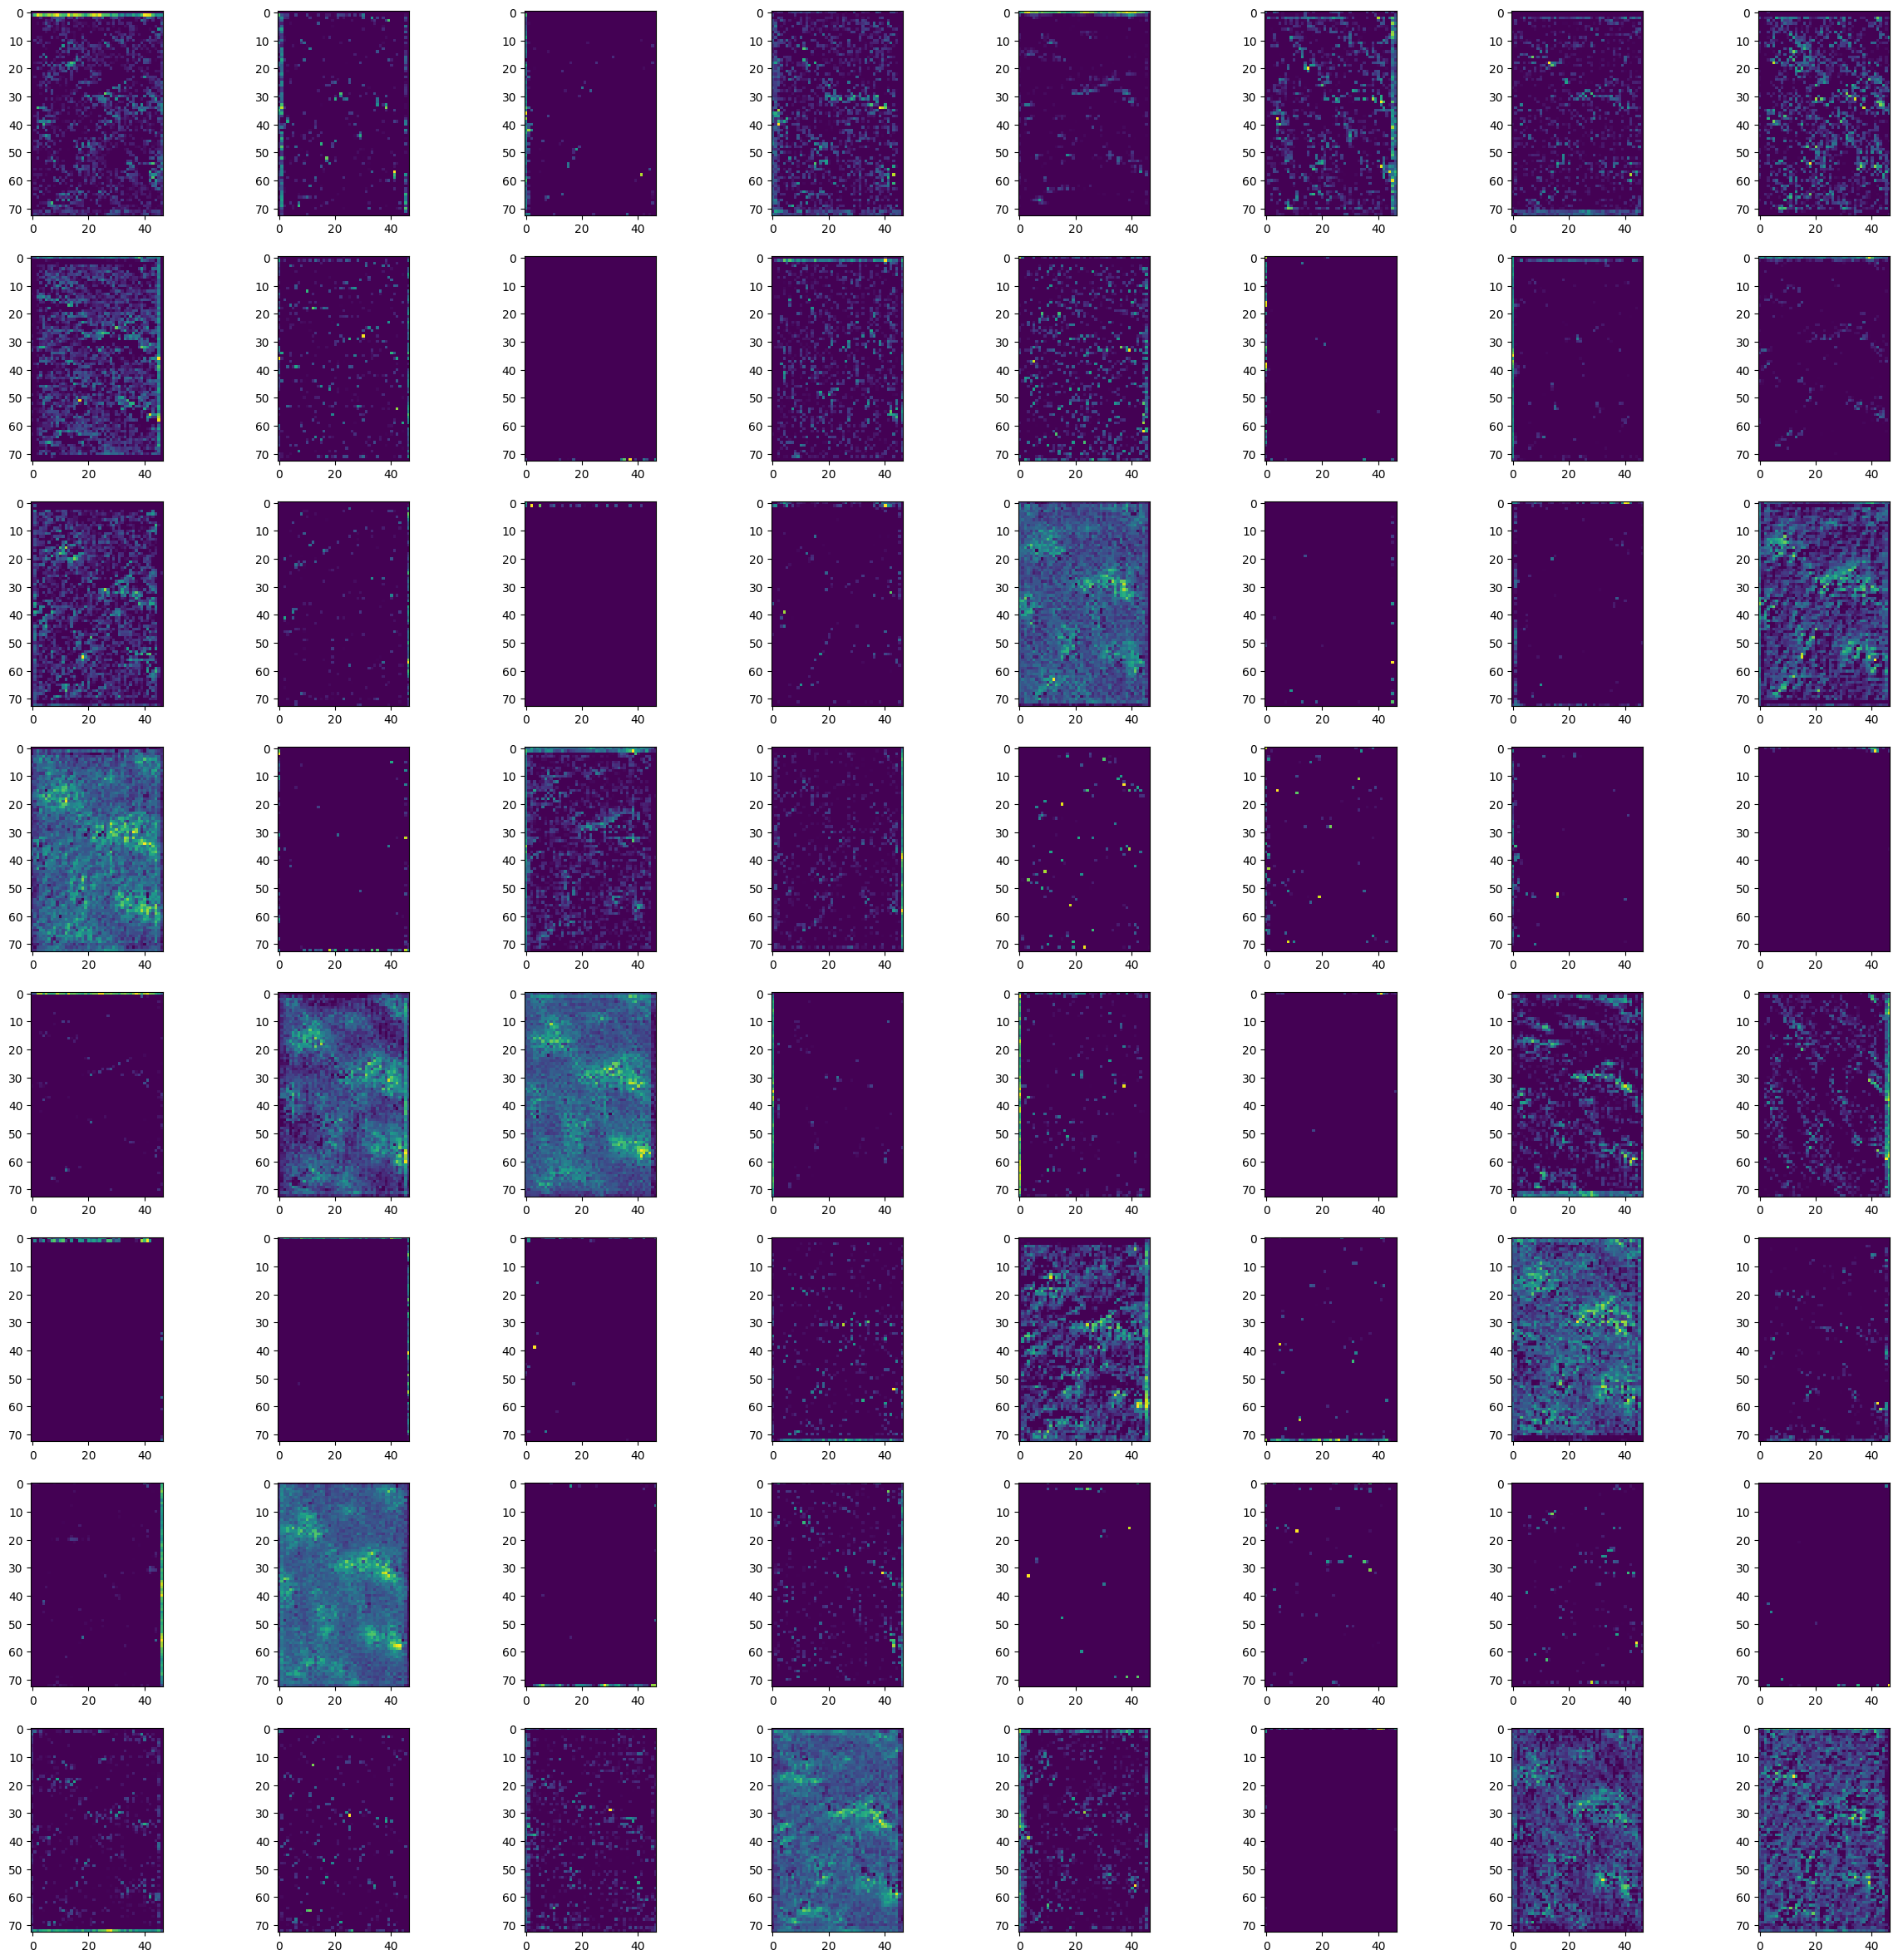

In [57]:
from keras import models
import math

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(aa)

i=15
layer = activations[i]
# print(layer.shape)
sqrt = int(math.sqrt(layer.shape[-1]))
ix = 1
plt.figure(figsize = (30, 30))
for j in range(sqrt):
  for k in range(sqrt):
    ax = plt.subplot(sqrt, sqrt, ix)
    plt.imshow(layer[0, :, :, ix-1])
    ix+=1


In [58]:
layer_names = []

for layer in model.layers:
  layer_names.append(layer.name)
print(layer_names)

['input_1', 'conv2d', 'conv2d_1', 'max_pooling2d', 'dropout', 'conv2d_2', 'conv2d_3', 'add', 'conv2d_4', 'max_pooling2d_1', 'dropout_1', 'conv2d_5', 'conv2d_6', 'add_1', 'conv2d_7', 'conv2d_8', 'conv2d_transpose', 'up_sampling2d_1', 'up_sampling2d', 'conv2d_9', 'add_2', 'conv2d_10', 'conv2d_11', 'conv2d_transpose_1', 'up_sampling2d_3', 'up_sampling2d_2', 'conv2d_12', 'add_3', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'add_4', 'conv2d_16']


### Loading Models

In [ ]:
#path = '/content/unet1.h5'

In [ ]:
#aaa = tf.keras.models.load_model(path, custom_objects={'loss':loss})

In [ ]:
# aaa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 292, 188, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 292, 188, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 292, 188, 16  6416        ['conv2d[0][0]']                 
                                )                                                             